Counter({'neutral': 86, 'surprise': 82, 'happy': 75, 'sadness': 41, 'anger': 40, 'fear': 16})
Counter({'neutral': 36, 'surprise': 35, 'happy': 30, 'anger': 18, 'sadness': 17, 'fear': 7})
Accuracy: 0.6363636363636364
Confusion Matrix:
 [[ 4  0  0 12  2  0]
 [ 0  0  0  3  4  0]
 [ 0  0 26  4  0  0]
 [ 1  0  1 28  1  5]
 [ 1  0  0  8  7  1]
 [ 0  0  0  9  0 26]]


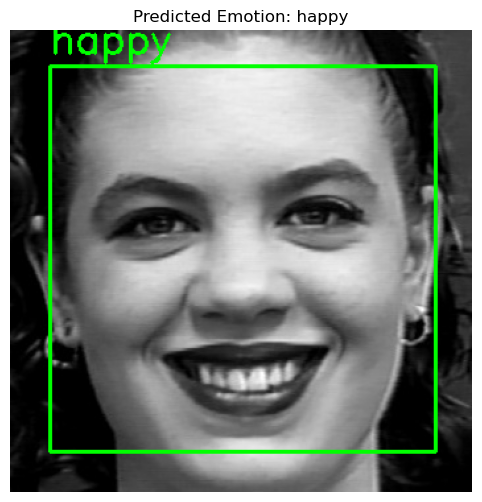

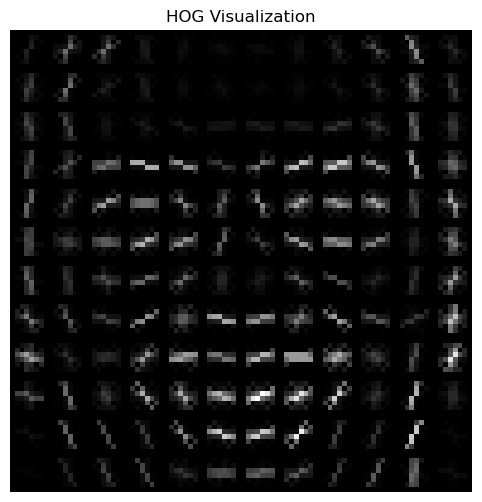

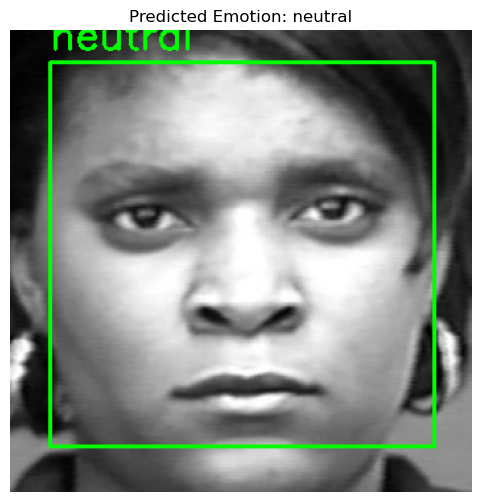

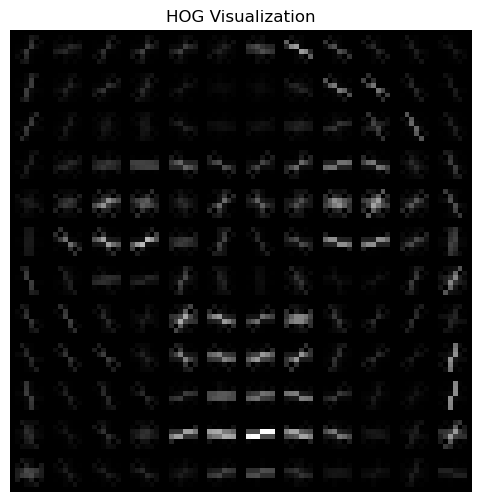

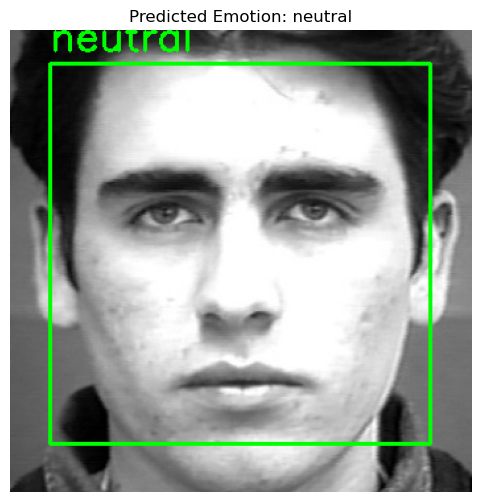

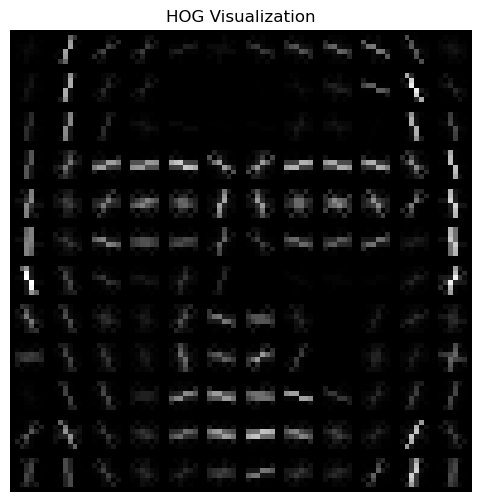

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from skimage.feature import hog
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


# Function to read in and detect facial images. 
def load_detect_faces(path):
    images = []
    labels = []
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y + h, x:x + w]
                        images.append(face_region)
                        labels.append(label)
    return images, labels  # I moved the return outside the loop


def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        img = cv2.equalizeHist(image)
        preprocessed_images.append(img)
    return preprocessed_images


def hog_feature_extraction(images):
    hog_features = []
    for image in images:
        image = cv2.resize(image, (96, 96))  # use 96 for more detail/pixels. 32 only produced 0.5 accuracy. 
        hog_feature = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(hog_feature)
    return np.array(hog_features)


train_folder_path = "CK_dataset/train/"
test_folder_path = "CK_dataset/test/"
# Load and process the data
X_train, y_train = load_detect_faces(train_folder_path)
X_test, y_test = load_detect_faces(test_folder_path)

class_imbalance_train = Counter(y_train)
class_imbalance_test = Counter(y_test)

print(class_imbalance_train)
print(class_imbalance_test)

X_train = preprocess_images(X_train)  # pre-processing training data enhances accuracy. 

X_train_features = hog_feature_extraction(X_train)
X_test_features = hog_feature_extraction(X_test)

# Build and train the SVM model

svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=7, gamma='scale', class_weight='balanced'))
svm.fit(X_train_features, y_train)

# Test the model
y_pred = svm.predict(X_test_features)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


def extract_face_hog(img):
    img = cv2.resize(img, (96, 96))
    hog_features, hog_image = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                                  block_norm='L2-Hys', visualize=True)
    return hog_features, hog_image


def predict_emotion(img_path, model):
    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image cannot be read.")

    # Convert to grayscale
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(grey_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        raise ValueError("No faces detected.")

    for (x, y, w, h) in faces:
        # Extract face region
        face_region = grey_img[y:y + h, x:x + w]

        # Extract HOG features
        hog_features, hog_image = extract_face_hog(face_region)
        hog_features = hog_features.reshape(1, -1)

        # Predict emotion
        pred_emotion = model.predict(hog_features)[0]

        # Visualise the results
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box around face
        cv2.putText(img_rgb, pred_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Show the image with predictions
        plt.figure(figsize=(10, 6))
        plt.imshow(img_rgb)
        plt.title(f"Predicted Emotion: {pred_emotion}")
        plt.axis("off")
        plt.show()

        # show the HOG visualisation
        plt.figure(figsize=(10, 6))
        plt.imshow(hog_image, cmap='gray')
        plt.title("HOG Visualization")
        plt.axis("off")
        plt.show()


# pick the first image from each emotion category.       
test_image_angry = "angry.jpg"
test_image_happy = "happy.jpg"
test_image_sad = "sad.jpg"

predict_emotion(test_image_happy, svm)
predict_emotion(test_image_angry, svm)
predict_emotion(test_image_sad, svm)